## 安装方式(release的最新版本)： 
安装vnpy_fxdayu:

https://github.com/xingetouzi/vnpy_fxdayu

## 配置引擎参数

In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180901 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

## 策略编写与参数设置

参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

## CtaTemplate 继承的属性与方法
1. self.symbolList: 支持多品种以列表格式输入引擎
2. self.posDict: 可记录多个品种的多空持仓的字典
3. self.cancelAll(): 取消所有订单
4. self.getArrayManager(symbol, freq): 数组管理器

In [2]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数（与参数列表对应）
    fastPeriod = 20     # 快速均线参数
    slowPeriod = 55    # 慢速均线参数
    lot = 1             # 设置手数
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        
        crossOver = (fastMa[-1]>slowMa[-1]) and (fastMa[-2]<=slowMa[-2]) # 金叉上穿 
        crossBelow = (fastMa[-1]<slowMa[-1]) and (fastMa[-2]>=slowMa[-2]) # 死叉下穿

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(DoubleMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function DoubleMaStrategy.on60MinBar at 0x11e40aae8>, <__main__.DoubleMaStrategy object at 0x11e3fc940>)
2018-12-05 21:08:26.819025	开始回测
2018-12-05 21:08:26.819294	策略初始化
2018-12-05 21:08:26.821693	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-05 21:08:27.942734	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-05 21:08:27.946038	载入完成，数据量：12000
2018-12-05 21:08:27.946521	策略初始化完成
2018-12-05 21:08:27.946581	策略启动完成
2018-12-05 21:08:27.946656	开始回放回测数据,回测范围:[20180901 12:00,20181123 12:00)
2018-12-05 21:08:27.957219	载入历史数据。数据范围:[20180901 12:00,20181123 12:00)
2018-12-05 21:08:36.071561	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-05 21:08:36.119030	载入完成，数据量：118890
2018-12-05 21:08:36.119527	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-05 21:08:36.125147	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018

In [4]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-13 18:00:00,空,,,0.0,,开仓,45,,5.3942,0.0,None,,,45,2018-11-13 18:00:00,1,45,EOSUSDT:binance,45
2018-11-14 01:00:00,多,,,0.0,,平仓,46,,5.4697,0.0,None,,,46,2018-11-14 01:00:00,1,46,EOSUSDT:binance,46
2018-11-14 01:00:00,多,,,0.0,,开仓,47,,5.4697,0.0,None,,,47,2018-11-14 01:00:00,1,47,EOSUSDT:binance,47
2018-11-14 03:00:00,空,,,0.0,,平仓,48,,5.1702,0.0,None,,,48,2018-11-14 03:00:00,1,48,EOSUSDT:binance,48
2018-11-14 03:00:00,空,,,0.0,,开仓,49,,5.1702,0.0,None,,,49,2018-11-14 03:00:00,1,49,EOSUSDT:binance,49


## 查看绩效回测绩效

2018-12-04 15:32:12.766361	计算按日统计结果
2018-12-04 15:32:12.831023	------------------------------
2018-12-04 15:32:12.832699	首个交易日：	2018-09-01 00:00:00
2018-12-04 15:32:12.833061	最后交易日：	2018-11-23 00:00:00
2018-12-04 15:32:12.833110	总交易日：	84
2018-12-04 15:32:12.833149	盈利交易日	39
2018-12-04 15:32:12.833186	亏损交易日：	42
2018-12-04 15:32:12.833223	起始资金：	1000000
2018-12-04 15:32:12.833427	结束资金：	1,000,002.22
2018-12-04 15:32:12.833530	总收益率：	0.0%
2018-12-04 15:32:12.833659	年化收益：	0.0%
2018-12-04 15:32:12.833885	总盈亏：	2.22
2018-12-04 15:32:12.833986	最大回撤: 	-1.26
2018-12-04 15:32:12.834061	百分比最大回撤: -0.0%
2018-12-04 15:32:12.834220	总手续费：	0.14
2018-12-04 15:32:12.834292	总滑点：	0.1
2018-12-04 15:32:12.834345	总成交金额：	271.25
2018-12-04 15:32:12.834532	总成交笔数：	49
2018-12-04 15:32:12.834625	日均盈亏：	0.03
2018-12-04 15:32:12.834700	日均手续费：	0.0
2018-12-04 15:32:12.834989	日均滑点：	0.0
2018-12-04 15:32:12.835104	日均成交金额：	3.23
2018-12-04 15:32:12.835174	日均成交笔数：	0.58
2018-12-04 15:32:12.835250	日均收益率：	0.0%
2018-12-04 15:32:12.835

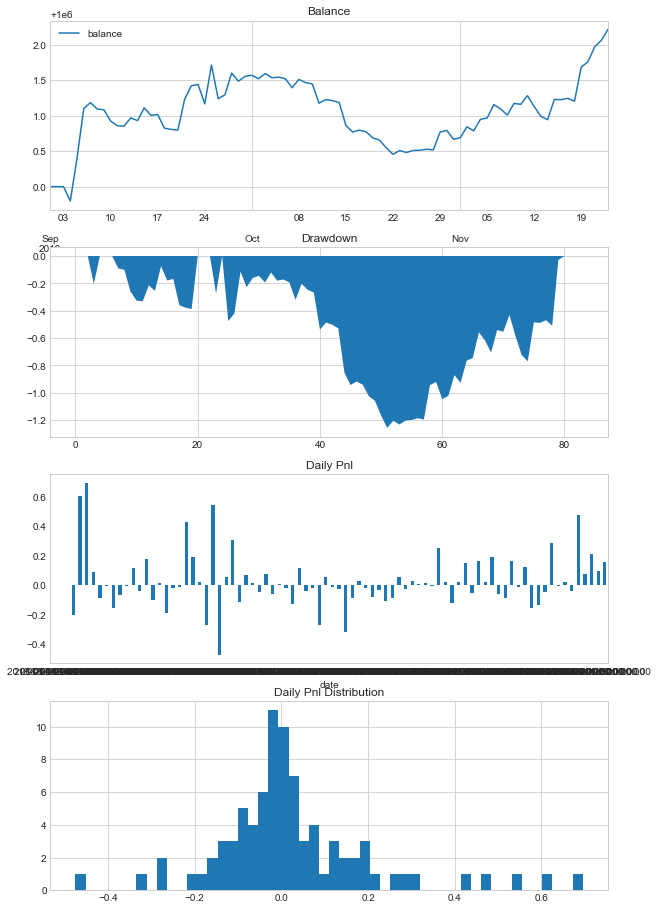

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-04 15:32:16.957189	计算回测结果
2018-12-04 15:32:16.962556	------------------------------
2018-12-04 15:32:16.963170	第一笔交易：	2018-09-05 00:00:00
2018-12-04 15:32:16.963260	最后一笔交易：	2018-11-23 11:58:00
2018-12-04 15:32:16.963324	总交易次数：	25
2018-12-04 15:32:16.963391	总盈亏：	2.21
2018-12-04 15:32:16.963596	最大回撤: 	-1.02
2018-12-04 15:32:16.963657	平均每笔盈利：	0.09
2018-12-04 15:32:16.963711	平均每笔滑点：	0.0
2018-12-04 15:32:16.963770	平均每笔佣金：	0.01
2018-12-04 15:32:16.964050	胜率		40.0%
2018-12-04 15:32:16.964123	盈利交易平均值	0.44
2018-12-04 15:32:16.964247	亏损交易平均值	-0.15
2018-12-04 15:32:16.964312	盈亏比：	2.99


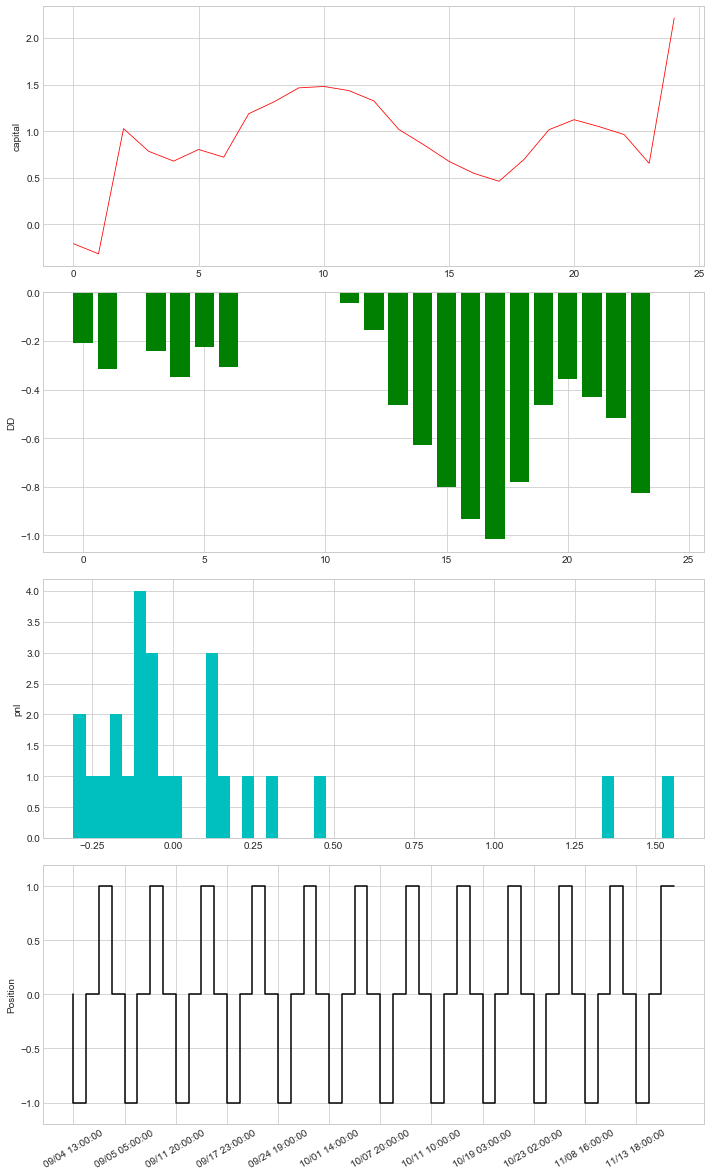

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [7]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-04 15:32:20.908348	计算按日统计结果


In [8]:
print(pd.Series(result)) # 显示绩效指标

annualizedReturn            0.000633478
dailyCommission              0.00161459
dailyNetPnl                   0.0263949
dailyReturn                 2.63949e-06
dailySlippage                0.00116667
dailyTradeCount                0.583333
dailyTurnover                   3.22919
endBalance                        1e+06
endDate             2018-11-23 00:00:00
lossDays                             42
maxDdPercent               -0.000125684
maxDrawdown                    -1.25684
profitDays                           39
returnStd                   1.85059e-05
sharpeRatio                     2.20961
startDate           2018-09-01 00:00:00
totalCommission                0.135626
totalDays                            84
totalNetPnl                     2.21717
totalReturn                 0.000221717
totalSlippage                     0.098
totalTradeCount                      49
totalTurnover                   271.252
dtype: object
